<a href="https://colab.research.google.com/github/abrahamgenetu/sync_intern_ai/blob/main/Handwritten_Digits_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abrahamgenetutaye","key":"c3af9f3f35a425327d8bc24ae3b4bb6f"}'}

In [2]:
!ls -lha kaggle.json

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 73 Oct 15 11:27 kaggle.json


In [3]:
!kaggle competitions download -c digit-recognizer

 39% 6.00M/15.3M [00:00<00:00, 61.7MB/s]
100% 15.3M/15.3M [00:00<00:00, 107MB/s] 


In [4]:
!unzip /content/digit-recognizer.zip -d digit-recognizer

Archive:  /content/digit-recognizer.zip
  inflating: digit-recognizer/sample_submission.csv  
  inflating: digit-recognizer/test.csv  
  inflating: digit-recognizer/train.csv  


In [5]:
import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense , Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
# filter warnings
warnings.filterwarnings('ignore')
# Input data files are available in the "../input/" directory.

import os

In [6]:
# Load training data
train = pd.read_csv('/content/digit-recognizer/train.csv')
display(train.head()) # Returns the first 5 rows
# display(train.tail()) # Returns the last 5 rows
print(f"train shape: {train.shape}")

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train shape: (42000, 785)


In [7]:
# Load testing data
test = pd.read_csv('/content/digit-recognizer/test.csv')
display(test.head()) # Returns the first 5 rows
# display(test.tail()) # Returns the last 5 rows
print(f"test shape: {test.shape}")

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


test shape: (28000, 784)


**Data Preparation**

In [10]:
# Preparing data for neural network
y_train = train["label"] # Put labels into y_train variable
X_train = train.drop(labels = ["label"],axis = 1) # Drop column 'label'

# Normalize the data
X_train = X_train / 255.0
X_test = test / 255.0
print(f"X_train shape: {X_train.shape}")
print(f"test shape: {test.shape}")

# Reshape
# Automatically_adjust_size, height, width, channels
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1, 28, 28, 1)
print('After Reshaping:')
print(f"X_train shape: {X_train.shape}")
print(f"test shape: {test.shape}")

# One-hot encoding: conversion of categorical info into a format that imporves prediction accuracy
y_train = to_categorical(y_train, num_classes = 10)
y_train

X_train shape: (42000, 784)
test shape: (28000, 784)
After Reshaping:
X_train shape: (42000, 28, 28, 1)
test shape: (28000, 28, 28, 1)


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [11]:
# train dataset: 80% validation dataset: 20%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=10)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (33600, 28, 28, 1)
y_train shape: (33600, 10)
X_val shape: (8400, 28, 28, 1)
y_val shape: (8400, 10)


**Data Visualization**

30 sample handwritten digits from training data set


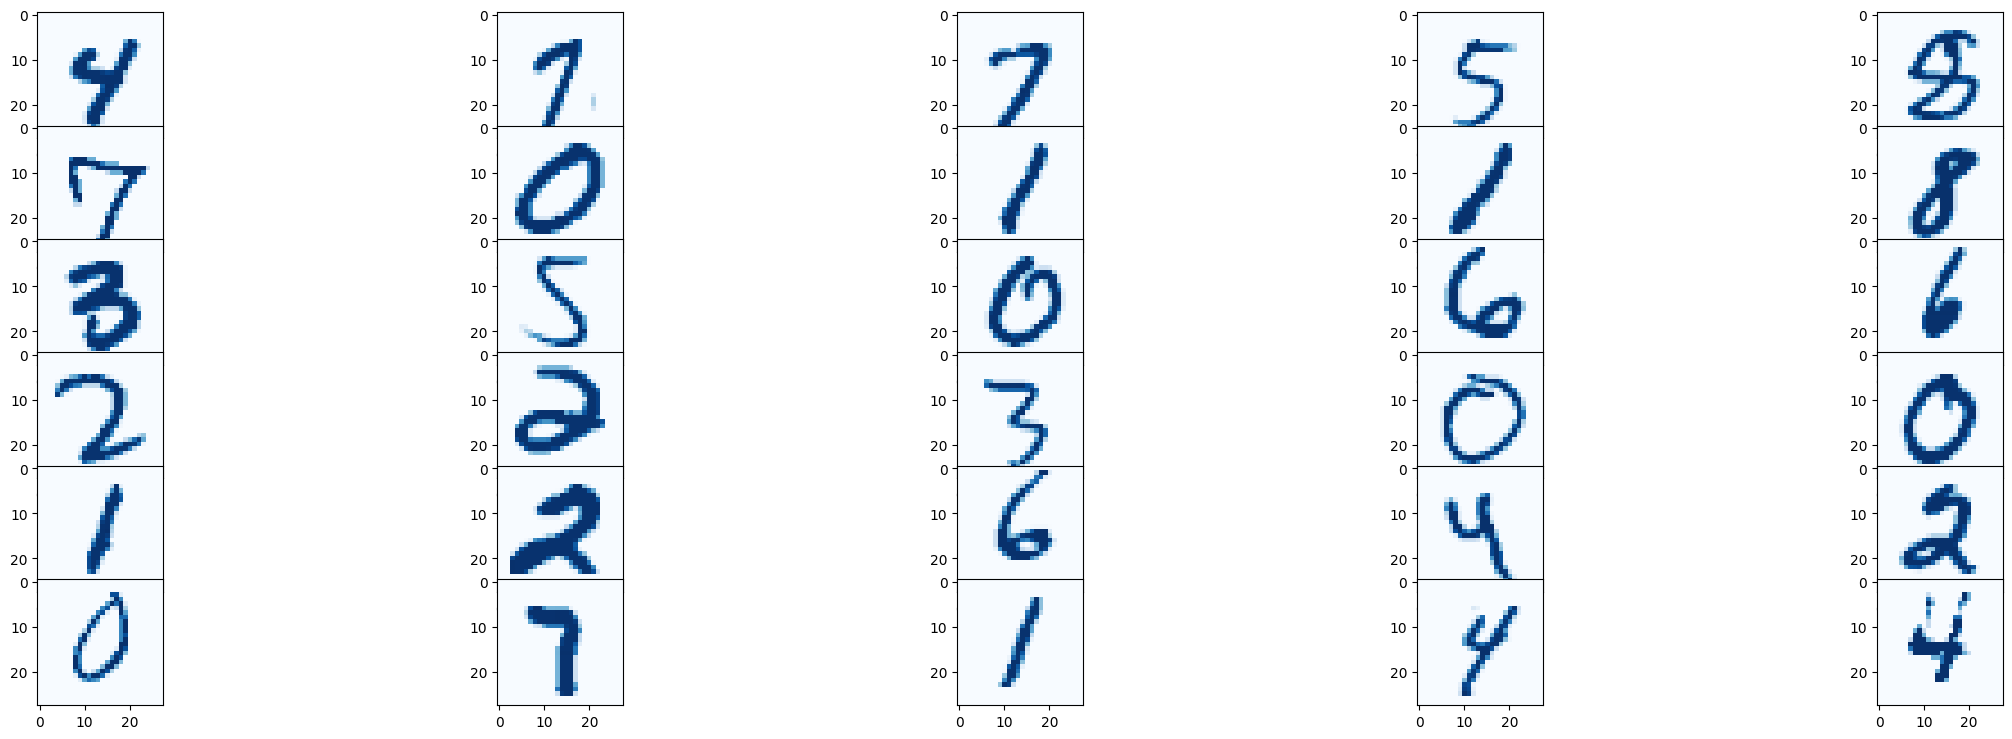

In [13]:
# Looking at some sample digits
print("30 sample handwritten digits from training data set" )
plt.figure(figsize=(30,9))
for i in range(30):
    plt.subplot(6, 10, (i+1)*2)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.Blues)
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

**Data Augumentation**

In [14]:
# 42000 training data and 28000 test data
# Create an ImageDataGenerator instance to augment the training data
image_data_gen = ImageDataGenerator(
        rotation_range=15,
        zoom_range = 0.10,
        width_shift_range=0.15,
        height_shift_range=0.15,)

image_data_gen.fit(X_train) # fit the data augmentation

Augmented sample 6


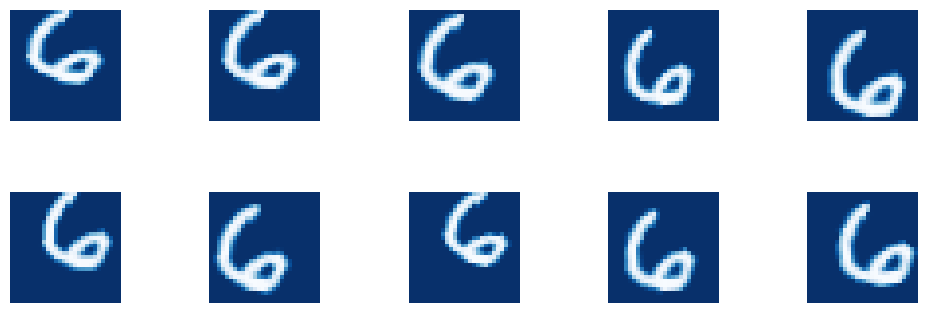

In [15]:
def plot_data_aug(number, index):
    X_train_i = X_train[index,].reshape((1,28,28,1))
    y_train_i = y_train[index,].reshape((1,10))

    print(f'Augmented sample {number}')
    plt.figure(figsize=(13,5))

    # plot the augmented samples
    for i in range(10):
        plt.subplot(2, 10, (i+1)*2)
        X_train_, y_train_ = image_data_gen.flow(X_train_i,y_train_i).next()
        plt.imshow(X_train_[0].reshape((28,28)),cmap=plt.cm.Blues.reversed())
        plt.axis('off')
    plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
    plt.show()

#Displaying augmented digits
plot_data_aug(6, index=13)
print('\n')
# plot_data_aug(5, index=3)

**Model Training**

In [16]:
# Build Convolutional Neural Networks
model = Sequential()
# relu is used as a activation function in the hiddlen layers
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Conv2D(filters=32, kernel_size=(5,5),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.1))


model.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size = (3,3),activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Flatten layer changes the two dimentional matrix to one dimensional array
# Softmax activation function is used on the output layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Set annealer
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# Set epochs and batch_size
epochs = 30
batch_size = 128

# Fit the model
history = model.fit(image_data_gen.flow(X_train,y_train, batch_size=batch_size), epochs = epochs, validation_data = (X_val,y_val),verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,callbacks=[annealer],)


Epoch 1/30
262/262 - 24s - loss: 1.1345 - accuracy: 0.6289 - val_loss: 6.7929 - val_accuracy: 0.0995 - lr: 0.0010 - 24s/epoch - 90ms/step
Epoch 2/30
262/262 - 11s - loss: 0.3649 - accuracy: 0.8882 - val_loss: 0.2146 - val_accuracy: 0.9360 - lr: 9.5000e-04 - 11s/epoch - 42ms/step
Epoch 3/30
262/262 - 10s - loss: 0.2407 - accuracy: 0.9282 - val_loss: 0.0589 - val_accuracy: 0.9815 - lr: 9.0250e-04 - 10s/epoch - 40ms/step
Epoch 4/30
262/262 - 10s - loss: 0.1838 - accuracy: 0.9474 - val_loss: 0.0416 - val_accuracy: 0.9865 - lr: 8.5737e-04 - 10s/epoch - 39ms/step
Epoch 5/30
262/262 - 11s - loss: 0.1586 - accuracy: 0.9544 - val_loss: 0.0402 - val_accuracy: 0.9885 - lr: 8.1451e-04 - 11s/epoch - 40ms/step
Epoch 6/30
262/262 - 11s - loss: 0.1327 - accuracy: 0.9609 - val_loss: 0.0380 - val_accuracy: 0.9877 - lr: 7.7378e-04 - 11s/epoch - 42ms/step
Epoch 7/30
262/262 - 11s - loss: 0.1212 - accuracy: 0.9638 - val_loss: 0.0352 - val_accuracy: 0.9890 - lr: 7.3509e-04 - 11s/epoch - 42ms/step
Epoch 8/30

**Plot of accuracy graph**

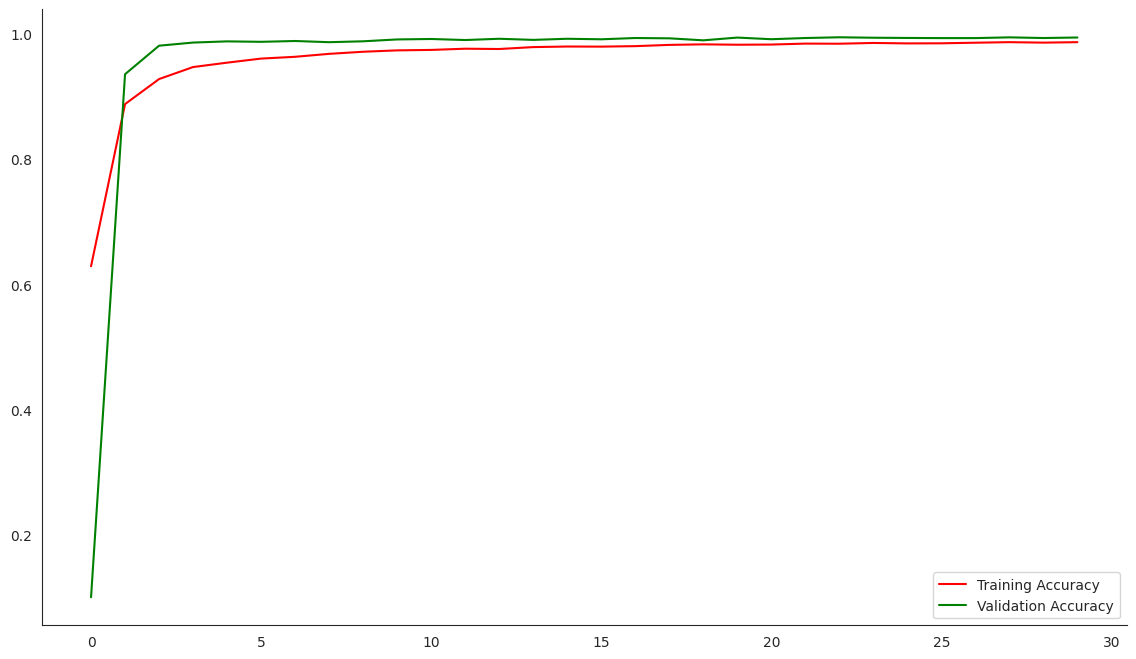

Maximum validation accuracy: 0.9950000047683716


In [20]:
plt.figure(figsize = (14, 8))
sns.set_style('white')
history_df = pd.DataFrame(history.history)
plt.plot(history.history['accuracy'], color='r', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='g', label="Validation accuracy")

plt.legend(['Training Accuracy', 'Validation Accuracy'])

sns.despine() # Remove borders
plt.show()
# print max validation accuracy
print("Maximum validation accuracy: {}".format(history_df['val_accuracy'].max()))

**Plot of loss graph**

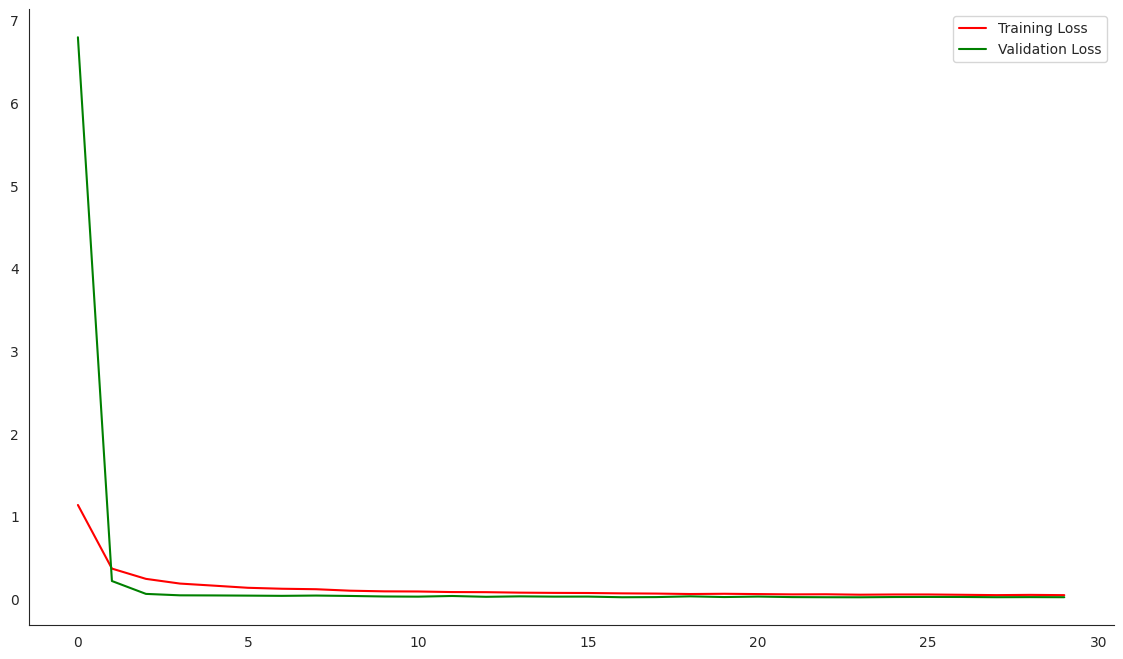

Minimum validation loss: 0.01795622892677784


In [22]:
plt.figure(figsize = (14, 8))
sns.set_style('white')

plt.plot(history.history['loss'], color='r', label="Training loss")
plt.plot(history.history['val_loss'], color='g', label="Validation loss")

plt.legend(['Training Loss', 'Validation Loss'])

sns.despine() # Remove borders
plt.show()
# Print min val loss
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 [==============================] - 2s 2ms/step
